# Personal Protection Equipment Detection model
Example of usage

### 1. Start the trial or buy our VitechLab PPE model on AWS Marketplace

### 2. Create a new endpoint using AWS SageMaker Console

### 3. Generating Prediction using `RealTimePredictor`

In [31]:
# deployment info
num_instances = 1
sagemaker_role = 'AmazonSageMaker-ExecutionRole'

In [44]:
import sagemaker as sage

endpoint_name=' your endpoint name'

sess = sage.Session()

predictor = sage.predictor.RealTimePredictor(
    model.endpoint_name,
    sagemaker_session=sess, 
    content_type="image/jpeg"
)

In [45]:
file_name = 'model_server/samples/sample1.jpg'

with open(file_name, 'rb') as image:
    f = image.read()
    image_bytes = bytearray(f)

prediction_result = predictor.predict(image_bytes).decode("utf-8")

In [46]:
import json

result = json.loads(prediction_result)
result

[[2967.0, 898.0, 3300.0, 1305.0, 0.989774227142334, 0.9958908557891846, 5.0],
 [2954.0, 710.0, 3320.0, 1831.0, 0.9793561697006226, 0.9999479055404663, 6.0],
 [2500.0, 1051.0, 2701.0, 1641.0, 0.9598415493965149, 0.9999502897262573, 6.0],
 [2503.0, 1145.0, 2687.0, 1336.0, 0.9575297832489014, 0.9994900226593018, 5.0],
 [2980.0, 717.0, 3179.0, 968.0, 0.9492455124855042, 0.9992179870605469, 1.0],
 [343.0, 193.0, 985.0, 1128.0, 0.9292994141578674, 0.9981414079666138, 5.0],
 [314.0, 30.0, 1084.0, 2052.0, 0.889924168586731, 0.9997428059577942, 6.0],
 [741.0, 1.0, 1210.0, 520.0, 0.7497022747993469, 0.9978610873222351, 1.0],
 [2515.0, 1040.0, 2621.0, 1158.0, 0.7181826233863831, 0.997736930847168, 1.0]]

In [47]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

classes = ['Bare Head', 'Helmet', 'Ear Protection', 'Welding Mask', 
           'Bare Chest', 'High Visibility Vest', 'Person']

def visualize_detection(img_file, dets):
        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        
        colors = dict()
        for det in dets:
            x0, y0, x1, y1, score, _, klass = det
            
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = x0
            ymin = y0
            xmax = x1
            ymax = y1
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

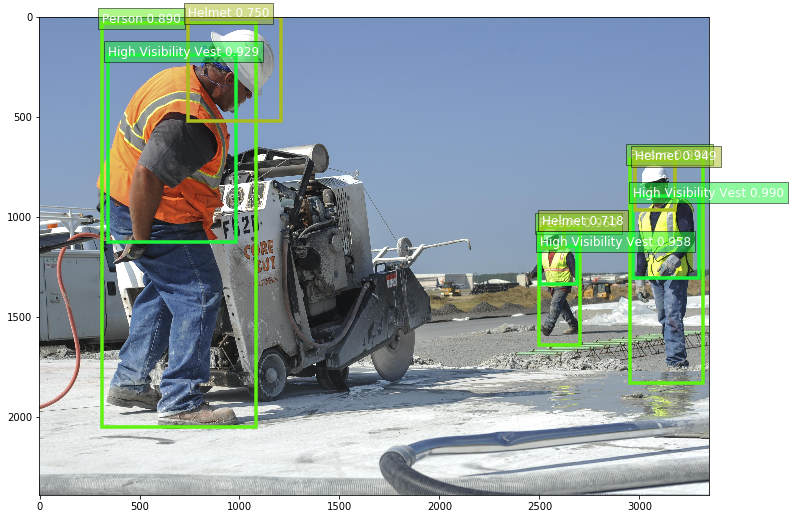

In [48]:
plt.rcParams['figure.figsize'] = [12, 12]
visualize_detection(file_name, result)

### Generate Prediction using Batch Transform

#### Uploading input data to S3

In [50]:
input_data_folder = 'batch_data/input'
s3_data_folder = 'ppe_model_batch_testing/input'

input_data_location = sess.upload_data(input_data_folder, key_prefix=s3_data_folder)
output_data_location = input_data_location.replace('input', 'output')

In [55]:
instance_type = ' your instance type '

transformer = model.transformer(instance_count=1,
                               instance_type=instance_type,
                               output_path=output_data_location,
                               strategy='SingleRecord',
                               assemble_with=None,
                               accept='image/jpeg')

Using already existing model: vitechlab-ppe-model-v2-1-2019-11-29-16-42-53-248


#### Starting a new Batch Transform Job

In [56]:
transformer.transform(input_data_location, 
    content_type='image/jpeg',
    compression_type=None,
    split_type=None,
    join_source=None)

transformer.wait()

In [71]:
dest_file = 'batch_data/output/result_example.txt'

bucket = sess.default_bucket()
s3 = sess.boto_session.resource('s3')


bucket = s3.Bucket(bucket)

obj = bucket.Object(output_data_location)
bucket.download_file('ppe_model_batch_testing/output/sample1.JPG.out', dest_file)

with open(dest_file, 'r') as file:
    print(file.read())

[[2967.0, 898.0, 3300.0, 1305.0, 0.989774227142334, 0.9958908557891846, 5.0], [2954.0, 710.0, 3320.0, 1831.0, 0.9793561697006226, 0.9999479055404663, 6.0], [2500.0, 1051.0, 2701.0, 1641.0, 0.9598415493965149, 0.9999502897262573, 6.0], [2503.0, 1145.0, 2687.0, 1336.0, 0.9575297832489014, 0.9994900226593018, 5.0], [2980.0, 717.0, 3179.0, 968.0, 0.9492455124855042, 0.9992179870605469, 1.0], [343.0, 193.0, 985.0, 1128.0, 0.9292994141578674, 0.9981414079666138, 5.0], [314.0, 30.0, 1084.0, 2052.0, 0.889924168586731, 0.9997428059577942, 6.0], [741.0, 1.0, 1210.0, 520.0, 0.7497022747993469, 0.9978610873222351, 1.0], [2515.0, 1040.0, 2621.0, 1158.0, 0.7181826233863831, 0.997736930847168, 1.0]]
